## Семинар 6 "Segmentation"

ФИО: Роор Даниил Дмитриевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output
import sys

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [6]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3] != 255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path / (item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [7]:
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
    
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((400, 400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((400, 400), interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()]
)
dataset = Dataset(train_data, s_trans, t_trans)

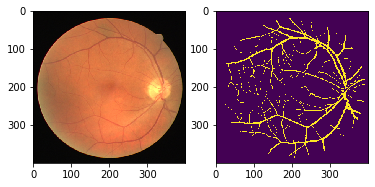

In [8]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [9]:
X_train = [dataset[i] for i in range (0, 20)]

### Rotation

In [10]:
def s_rotator(angle):    
    s_trans = tsf.Compose([
        tsf.ToPILImage(),
        tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
            translate=(0, 0), scale=1, 
            shear = False)),
        tsf.Resize((400, 400)),
        tsf.ToTensor(),
        tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
    ]
    )
    
    return s_trans
  
def t_rotator(angle):
    t_trans = tsf.Compose([
        tsf.ToPILImage(),
        tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
            translate=(0, 0), scale=1,
            shear = False)),
        tsf.Resize((400, 400), interpolation=PIL.Image.NEAREST),
        tsf.ToTensor()]
    )
    
    return t_trans

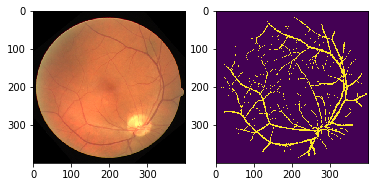

In [11]:
rotated_dataset = Dataset(train_data, s_rotator(50), t_rotator(50))
img, mask = rotated_dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [12]:
for angle in range(5, 360, 5):
    rotated_dataset = Dataset(train_data, s_rotator(angle), t_rotator(angle))
    for i in range(0, 20):
        X_train.append(rotated_dataset[i])

In [13]:
len(X_train)

1440

### Train

In [14]:
dtype=t.FloatTensor

def _epoch(network, loss, loader, optimizer):
    losses = []
    for X, y in loader:
        X = X.type(dtype)
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, loss):
    optimizer = t.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.train()
    try:
        for epoch in tqdm(range(epochs)):
            losses = _epoch(network, loss, train_loader, optimizer)
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... Loss: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

### UNet

In [15]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

In [16]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
        score = 1 - score.sum()/num
        return score

In [17]:
train_loader = t.utils.data.DataLoader(X_train, batch_size=4, shuffle=True)

In [ ]:
model = UNet(3, 1)
train(model, train_loader, 10, 0.01, soft_dice_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

### Test

In [ ]:
t.save(model, 'unet10epochs.pth.tar')
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((400, 400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [ ]:
#os.makedirs("result")

In [ ]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(tm)

## Выводы

Сначала пробовала UNet с данными без аугментации - score с соревновании был в районе 0.6. При использовании в качестве loss-функции MSE результат ухудшился. 

При применении аугментации к данным (картинки поворачивались под разными углами) score вырос до 0.6852 на той же сети UNet. На тех же данных были опробованы также ResNet (результат ухудшился), SegNet (результат очень необычный):

<img height = '200px' src="pics/segnet.png">

Далее я решила попробовать предобученные модели с использованием библиотеки segmentation_models_pytorch. Результат тоже получился довольно забавный, возможно, данных, на которых тренируется уже натренированная сеть, было слишком мало. Вот, например, результат использования resnet:

<img height = '200px' src="pics/resnet.png">

Далее я решила поработать с результатом, полученным на UNet, сначала увеличила разрешение (размер) картинок, потому что размер 128*128 существенно ухудшает результат. Это сразу подняло score до 0.78. При увеличении тренировочных данных и числа эпох обучения, удалось получить score, равный 0.8028. Название команды на лидерборде - [sphere] A. Bogatenkova.